# Probability of killing proportional to $O_2$ concentration

## Imports

In [13]:
import os

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from scipy.integrate import solve_bvp

from tumorsphere.core.simulation import Simulation

sns.set_theme(style="darkgrid")

## Parameters

In [7]:
# Parameters
cellular_radius_in_microns = 8  # microns (this is the value for )
spheroid_radius_in_cellular_radii = 40  # case with tf = 28
spheroid_radius_in_microns = (
    spheroid_radius_in_cellular_radii * cellular_radius_in_microns
)

# Parameter L = \sqrt{D / k}, where D is the diffusion coefficient and k is
# the consumption constant, experimentally determined to be 100 microns
l_in_microns = 100

## Diffusion Equation Solution
### Solving the ODEs

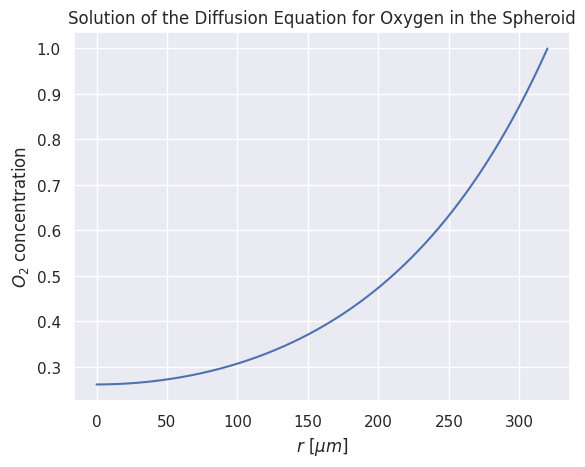

In [19]:
# ------ Define the system of ODEs ------


def odes(r, y, l_in_microns):
    """
    Defines the system of ODEs for the diffusion equation.

    Here, y = [y0, y1] = [f(r), df/dr], where f(r) is the concentration of the
    diffusing oxygen and df/dr is the derivative of f with respect to r. The
    original diffusion equation with spherical symmetry is given by:
    d^2f/fr^2 + (2/r)df/dr - f/L^2 = 0
    where L = sqrt(D / k), where D is the diffusion coefficient and k is the
    consumption constant. Then, the system of ODEs is:
    dy0/dr = y1
    dy1/dr = y0 / L^2 - (2 / r) * y1

    Parameters
    ----------
    r : float or ndarray
        Radial coordinate(s) at which to evaluate the ODEs.
    y : ndarray
        Array containing the dependent variables [f(r), df/dr].
    l_in_microns : float
        Parameter L = sqrt(D / k), where D is the diffusion coefficient
        and k is the consumption constant.

    Returns
    -------
    dydr : ndarray
        Array containing the derivatives [df/dr, d^2f/dr^2].
    """
    y0, y1 = y
    dy0_dr = y1
    dy1_dr = y0 / l_in_microns**2 - (2 / r) * y1
    return np.vstack((dy0_dr, dy1_dr))


# ------ Define the boundary conditions ------


def bc(ya, yb):
    """
    Defines the boundary conditions for the ODE system.

    The function bc returns an array containing the residuals for each
    boundary condition. A residual is the difference between the desired value
    and the actual value provided by the solution. *So residuals are what we
    want to be zero.* The boundary conditions for the diffusion equation are:
    1. df/dr (r=0) = 0, i.e., ya[0] = 0
    (no flux at the center of the spheroid);
    2. f(r=R) = 1, i.e., yb[1] = 1  =>  yb[1] - 1 = 0
    (oxygen concentration at the surface of the spheroid is 1).


    Parameters
    ----------
    ya : ndarray
        Array containing the values of y(r=a) = [y0(r=a), y1(r=a), ...].
        In this case, a = 0, so,
        ya = y(r=0) = [y0(r=0), y1(r=0)] = [f(0), df/dr(0)].
    yb : ndarray
        Array containing the values of y(r=b) = [y0(r=b), y1(r=b), ...].
        In this case, b = R, so,
        yb = y(r=R) = [y0(r=R), y1(r=R)] = [f(R), df/dr(R)].

    Returns
    -------
    bcs : ndarray
        Array containing the residuals of the boundary conditions
        [df/dr (r=0), f(r=R) - 1].
    """
    return np.array([ya[1], yb[0] - 1])


# Vector of radial coordinates
r = np.linspace(1e-5, spheroid_radius_in_microns, 50000)

# Initial guess for f(r)
y_guess = np.zeros((2, r.size))
y_guess[0] = 1

# Solve the BVP
sol = solve_bvp(
    lambda r, y: odes(r, y, l_in_microns), bc, r, y_guess, max_nodes=50000
)

# Check if the solution was successful
if sol.status != 0:
    print("The solver did not converge!")

# We save the solution to a DataFrame where:
# - r is the radial spherical coordinate in microns;
# - f(r) is the oxygen concentration.
concentration_O2 = pd.DataFrame({"r": sol.x, "f(r)": sol.y[0]})


# Plot the responses for different events and regions
sns.lineplot(data=concentration_O2, x="r", y="f(r)")
plt.xlabel("$r$ [$\mu m$]")
plt.ylabel("$O_2$ concentration")
plt.title("Solution of the Diffusion Equation for Oxygen in the Spheroid")
plt.show()

### Reading the Simulation Data

In [5]:
# Let's load the data for ps=0.6
df = pd.read_csv(
    "radiotherapy_active_targeted_culture_pd=0_ps=0.6_rng_seed=1099062448631258.csv"
)

# We drop the old index column
df.drop(columns=["Unnamed: 0"], inplace=True)

# Now, we rename position_norm to position_norm_in_radii
df.rename(columns={"position_norm": "position_norm_in_radii"}, inplace=True)

# Let's add a new column with the position in microns
df["position_norm_in_microns"] = (
    df["position_norm_in_radii"] * cellular_radius_in_microns
)

df.head()

,position_norm_in_radii,stemness,active,susceptibility,position_norm_in_microns
0,0.000000,True,False,0.967860,0.000000
1,2.000000,True,False,0.104409,16.000000
2,2.000000,False,False,0.111724,16.000000
3,2.974926,False,False,0.979707,23.799412
4,4.683681,False,False,0.621547,37.469450


### Interpolation of $O_2$ concentration
To know how much oxygen each cell has, we do a linear interpolation of `f(r)` at `position_norm_in_microns`.

In [25]:
# Interpolating to find the corresponding f(r) for each position_norm_in_microns
df["avg_O2_conc"] = np.interp(
    x=df["position_norm_in_microns"],
    xp=concentration_O2["r"],
    fp=concentration_O2["f(r)"],
)

df.head()

,position_norm_in_radii,stemness,active,susceptibility,position_norm_in_microns,avg_O2_conc
0,0.000000,True,False,0.967860,0.000000,0.261312
1,2.000000,True,False,0.104409,16.000000,0.262429
2,2.000000,False,False,0.111724,16.000000,0.262429
3,2.974926,False,False,0.979707,23.799412,0.263786
4,4.683681,False,False,0.621547,37.469450,0.267470


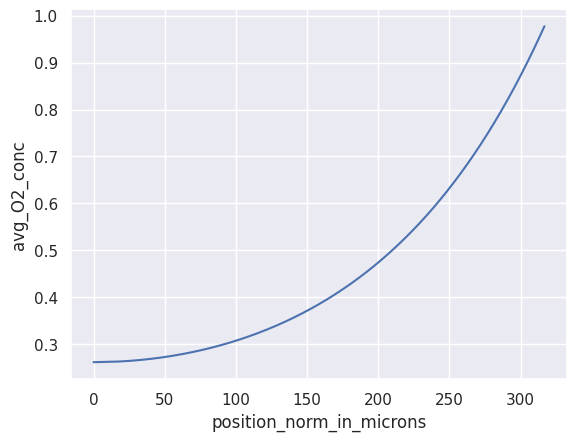

In [28]:
sns.lineplot(data=df, x="position_norm_in_microns", y="avg_O2_conc")
plt.show()

### Survival Probability

In [30]:
# s = 1 - f(r)
df["survival_probability"] = 1 - df["avg_O2_conc"]

# we kill when survival_probability < susceptibility (a random number)
df["killed"] = df["survival_probability"] < df["susceptibility"]

df.head()

,position_norm_in_radii,stemness,active,susceptibility,position_norm_in_microns,avg_O2_conc,survival_probability,killed
0,0.000000,True,False,0.967860,0.000000,0.261312,0.738688,True
1,2.000000,True,False,0.104409,16.000000,0.262429,0.737571,False
2,2.000000,False,False,0.111724,16.000000,0.262429,0.737571,False
3,2.974926,False,False,0.979707,23.799412,0.263786,0.736214,True
4,4.683681,False,False,0.621547,37.469450,0.267470,0.732530,False


### Exploration

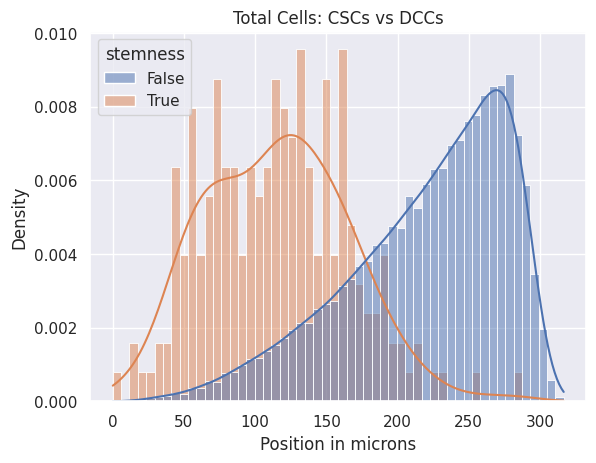

In [41]:
sns.histplot(
    data=df,
    x="position_norm_in_microns",
    hue="stemness",
    kde=True,
    common_norm=False,
    stat="density",
)
plt.title("Total Cells: CSCs vs DCCs")
plt.xlabel("Position in microns")
plt.show()

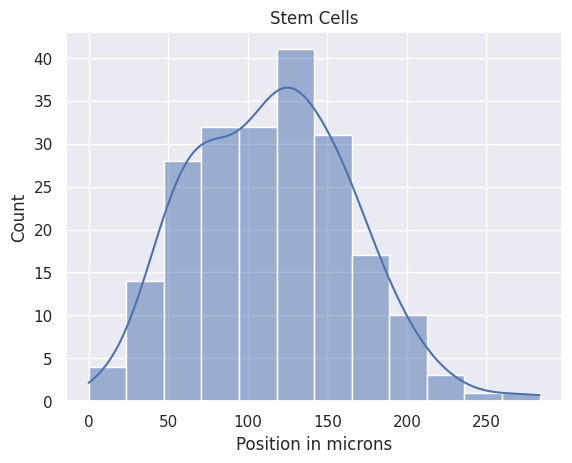

In [42]:
df_stem = df[df["stemness"]]
sns.histplot(data=df_stem, x="position_norm_in_microns", kde=True)
plt.title("Stem Cells")
plt.xlabel("Position in microns")
plt.show()

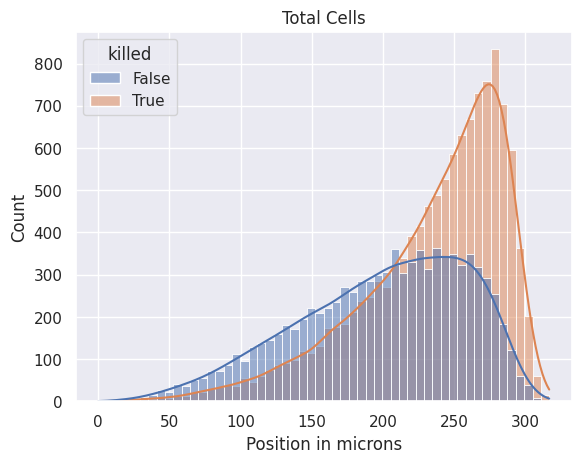

In [33]:
sns.histplot(data=df, x="position_norm_in_microns", hue="killed", kde=True)
plt.title("Total Cells: killed vs alive")
plt.xlabel("Position in microns")
plt.show()

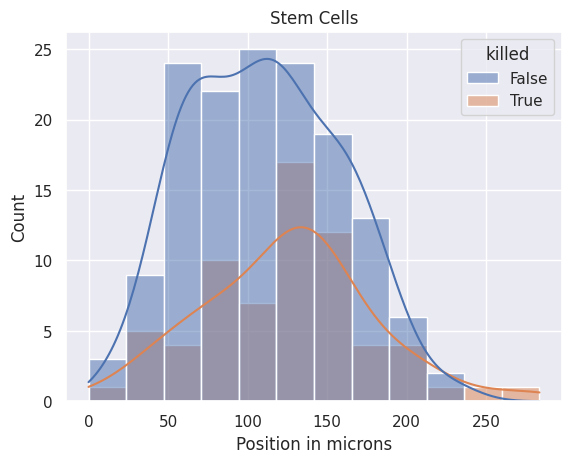

In [35]:
df_stem = df[df["stemness"]]
sns.histplot(
    data=df_stem, x="position_norm_in_microns", hue="killed", kde=True
)
plt.title("Stem Cells")
plt.xlabel("Position in microns")
plt.show()

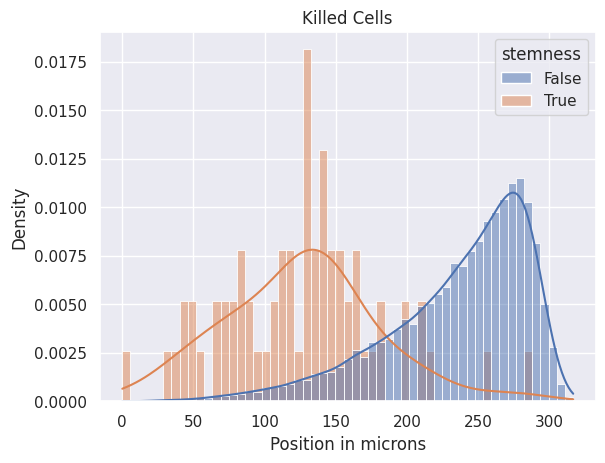

In [39]:
df_killed = df[df["killed"]]
sns.histplot(
    data=df_killed,
    x="position_norm_in_microns",
    hue="stemness",
    kde=True,
    common_norm=False,
    stat="density",
)
plt.title("Killed Cells")
plt.xlabel("Position in microns")
plt.show()

### Percentage Alive vs location

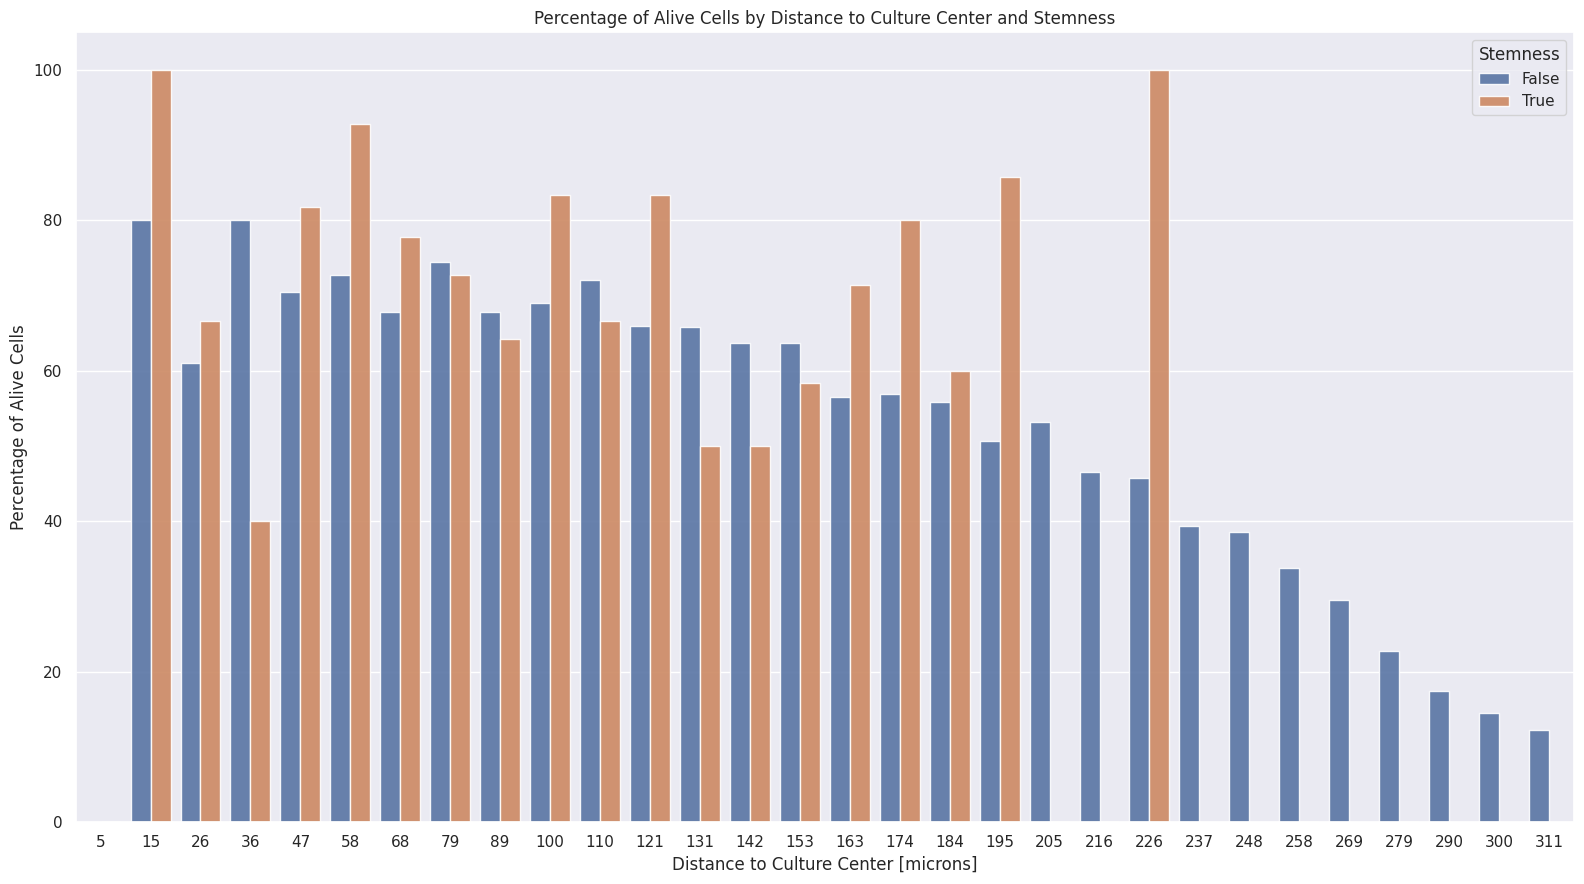

In [71]:
# Step 1: Create Bins
bins = 30  # Number of bins
df["bin"] = pd.cut(df["position_norm_in_microns"], bins=bins)

# Step 2: Calculate Alive and Total Counts per Bin and Stemness
# Total counts per bin and stemness
total_counts = (
    df.groupby(["bin", "stemness"], observed=True)
    .size()
    .reset_index(name="total")
)

# Alive counts per bin and stemness
alive_counts = (
    df[df["killed"] == False]
    .groupby(["bin", "stemness"], observed=True)
    .size()
    .reset_index(name="alive")
)

# Merge total and alive counts
counts = pd.merge(
    total_counts, alive_counts, on=["bin", "stemness"], how="left"
)
counts["alive"] = counts["alive"].fillna(
    0
)  # Replace NaN with 0 for bins with no alive cells

# Calculate Alive Percentage
counts["alive_percentage"] = (counts["alive"] / counts["total"]) * 100

# Step 3: Prepare X-axis Labels
# Convert bin intervals to midpoint string for categorical x-axis
counts["bin_mid"] = counts["bin"].apply(lambda x: int((x.left + x.right) / 2))

# Set the style
sns.set(style="darkgrid")  # Set plot style

plt.figure(figsize=(16, 9))  # Set figure size

# Create bar plot
ax = sns.barplot(
    data=counts,
    x="bin_mid",  # Use midpoint bin labels
    y="alive_percentage",
    hue="stemness",
    dodge=True,
    alpha=0.9,
)

# Correct the alignment of x-tick labels
plt.xticks(rotation=0, ha="center")

# Set axis labels and title
plt.xlabel("Distance to Culture Center [microns]")
plt.ylabel("Percentage of Alive Cells")
plt.title(
    "Percentage of Alive Cells by Distance to Culture Center and Stemness"
)

# Adjust layout to ensure everything fits without overlapping
plt.tight_layout()

# Display legend appropriately
plt.legend(title="Stemness", loc="upper right")

# Show plot
plt.show()